In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bybit import get_kline
from exceptions import FileNotFoundError

In [ ]:
input_file_path = "input.csv"

if not os.path.exists(input_file_path):
    raise FileNotFoundError("input.csv", input_file_path)

tickers_df = pd.read_csv(input_file_path)
tickers_data_df = pd.DataFrame(
    columns=[
        "ticker", "timestamp", "open_price", "highest_price", "lowest_price", "close_price"
    ]
)

tickers = list(tickers_df["Tickers"].values)

for ticker in tickers:
    result = get_kline(
        symbol=ticker,
        interval="D",
        limit=365
    )

    for item in result["result"]["list"]:   
        tickers_data_df.loc[-1] = \
            [ticker, item[0], item[1], item[2], item[3], item[4]]
        
        tickers_data_df.index += 1
        tickers_data_df = tickers_data_df.sort_index()

In [3]:
tickers_data_df["timestamp"] = pd.to_datetime(tickers_data_df["timestamp"].astype(int), unit="ms")

num_cols = ["open_price", "highest_price", "lowest_price", "close_price"]
for col in num_cols:
    tickers_data_df[col] = pd.to_numeric(tickers_data_df[col])

In [4]:
tickers_data_df.head()

,ticker,timestamp,open_price,highest_price,lowest_price,close_price
0,TRUMPUSDT,2025-01-18,24.200,34.766,18.000,28.429
1,TRUMPUSDT,2025-01-19,28.429,83.041,24.226,46.658
2,TRUMPUSDT,2025-01-20,46.658,64.000,34.505,36.553
3,TRUMPUSDT,2025-01-21,36.553,48.438,30.185,43.771
4,TRUMPUSDT,2025-01-22,43.771,44.583,36.040,36.884


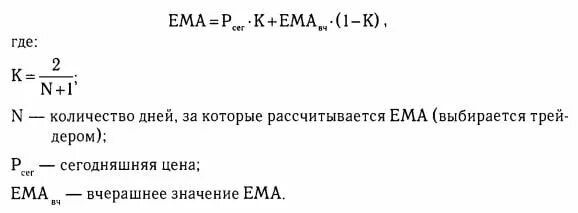 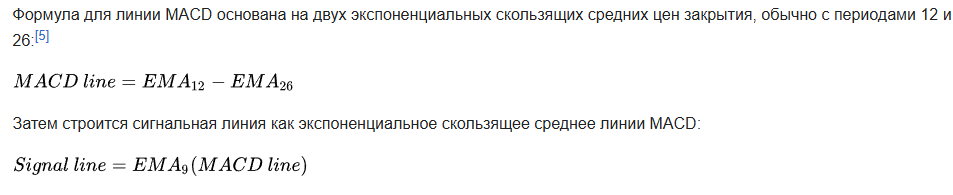 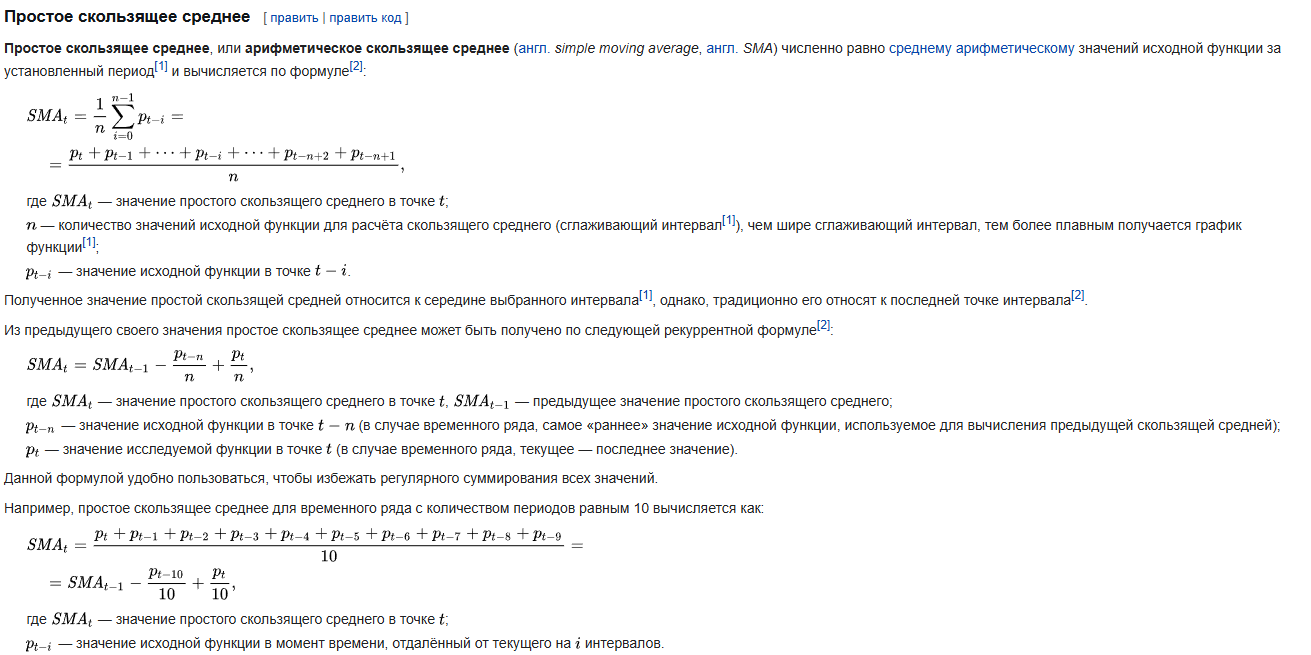

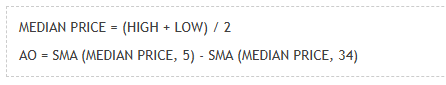
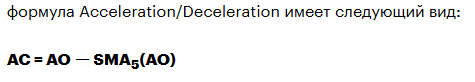

In [5]:
new_columns = ["MACD", "signal", "AO", "AC"]
for col in new_columns:
    tickers_data_df[col] = np.nan

for ticker in list(tickers_data_df["ticker"].unique()):
    mask = tickers_data_df["ticker"] == ticker
    ticker_df = tickers_data_df.loc[mask].copy()
    
    ticker_df["short_ema"] = ticker_df["close_price"].ewm(span=12, adjust=False).mean()
    ticker_df["long_ema"] = ticker_df["close_price"].ewm(span=26, adjust=False).mean()
    
    ticker_df["MACD"] = ticker_df["short_ema"] - ticker_df["long_ema"]
    ticker_df["signal"] = ticker_df["MACD"].ewm(span=9, adjust=False).mean()
    
    ticker_df["median_price"] = (ticker_df["highest_price"] + ticker_df["lowest_price"]) / 2
    ticker_df["short_sma"] = ticker_df["median_price"].rolling(window=5).mean()
    ticker_df["long_sma"] = ticker_df["median_price"].rolling(window=34).mean()
    ticker_df["AO"] = ticker_df["short_sma"] - ticker_df["long_sma"]

    ticker_df["ao_sma_5"] = ticker_df["AO"].rolling(window=5).mean()
    ticker_df["AC"] = ticker_df["AO"] - ticker_df["ao_sma_5"]
    
    tickers_data_df.loc[mask] = ticker_df.drop(
        columns=[
            "short_ema", "long_ema", "median_price", "short_sma", "long_ema",
            "ao_sma_5"
        ]
    )
    
tickers_data_df["histogram"] = tickers_data_df["MACD"] - tickers_data_df["signal"]

In [6]:
tickers_data_df.to_csv("output.csv")

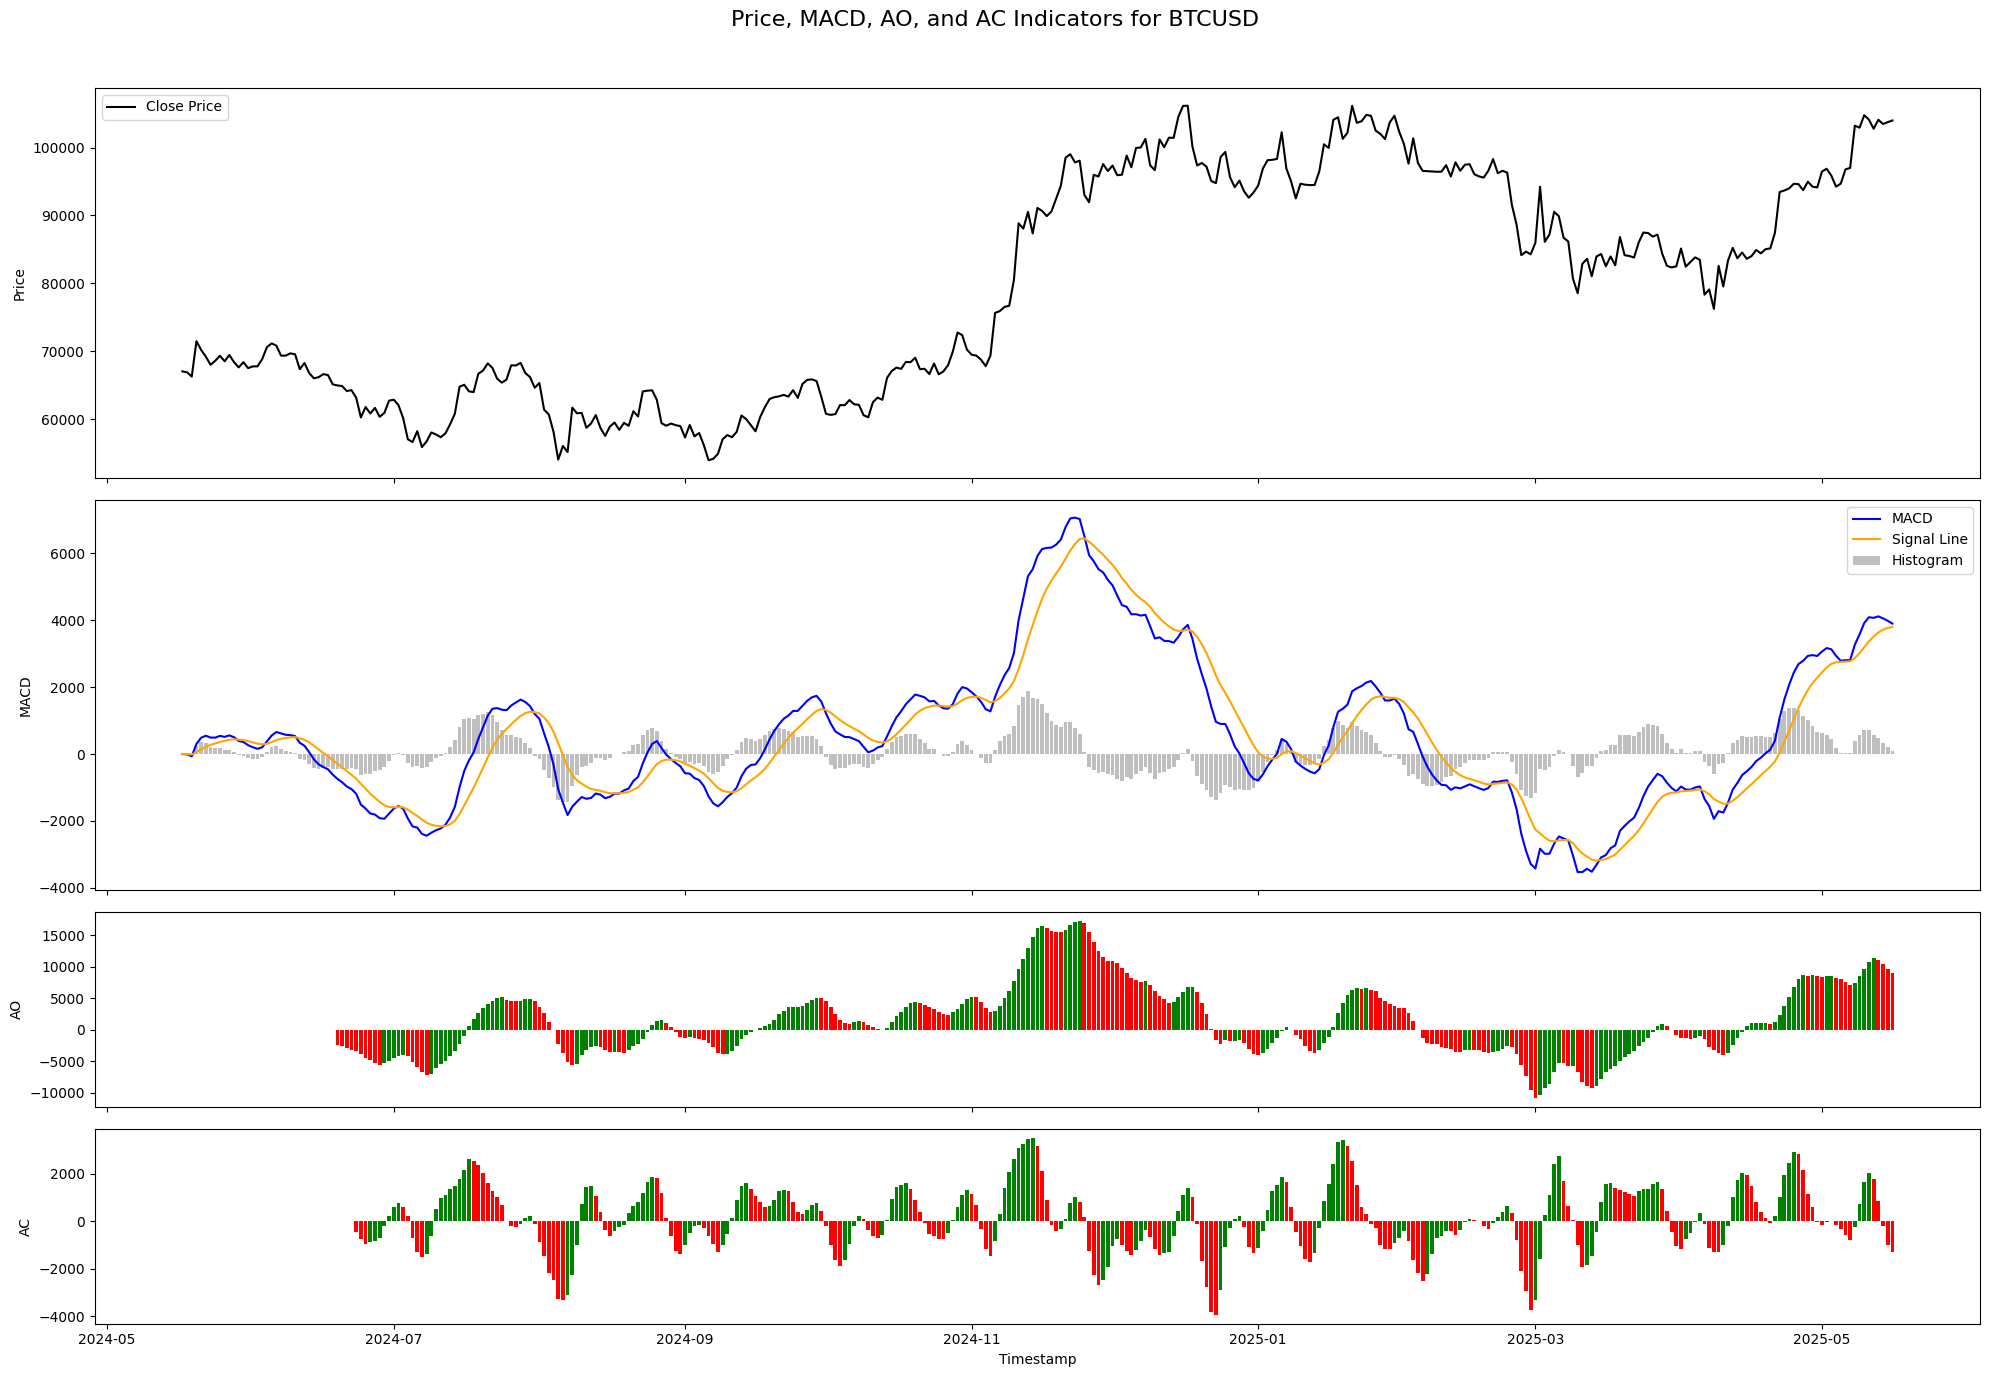

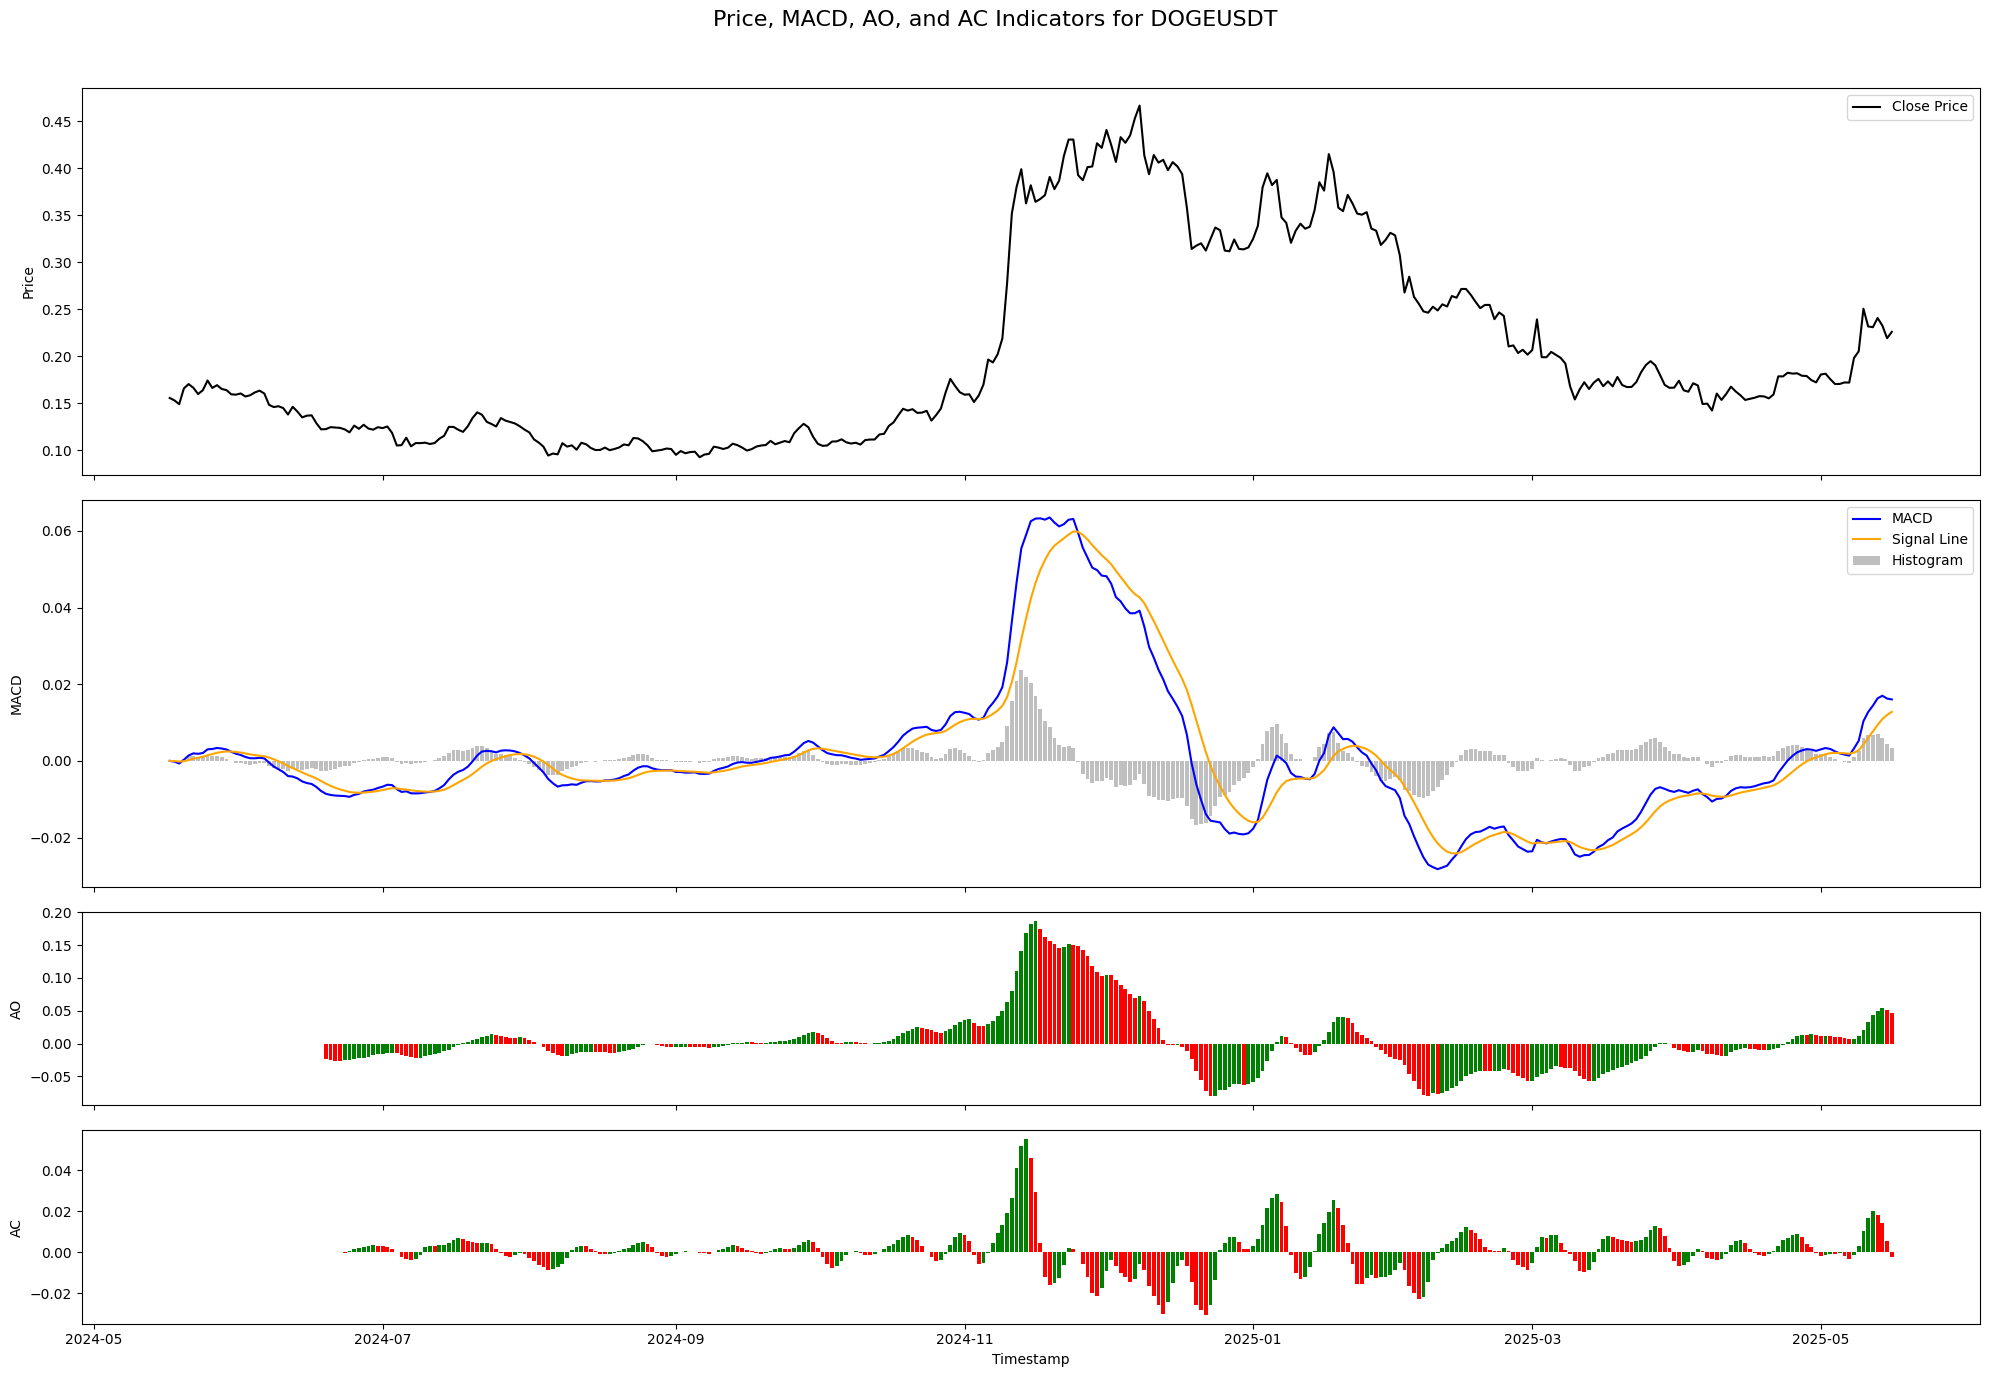

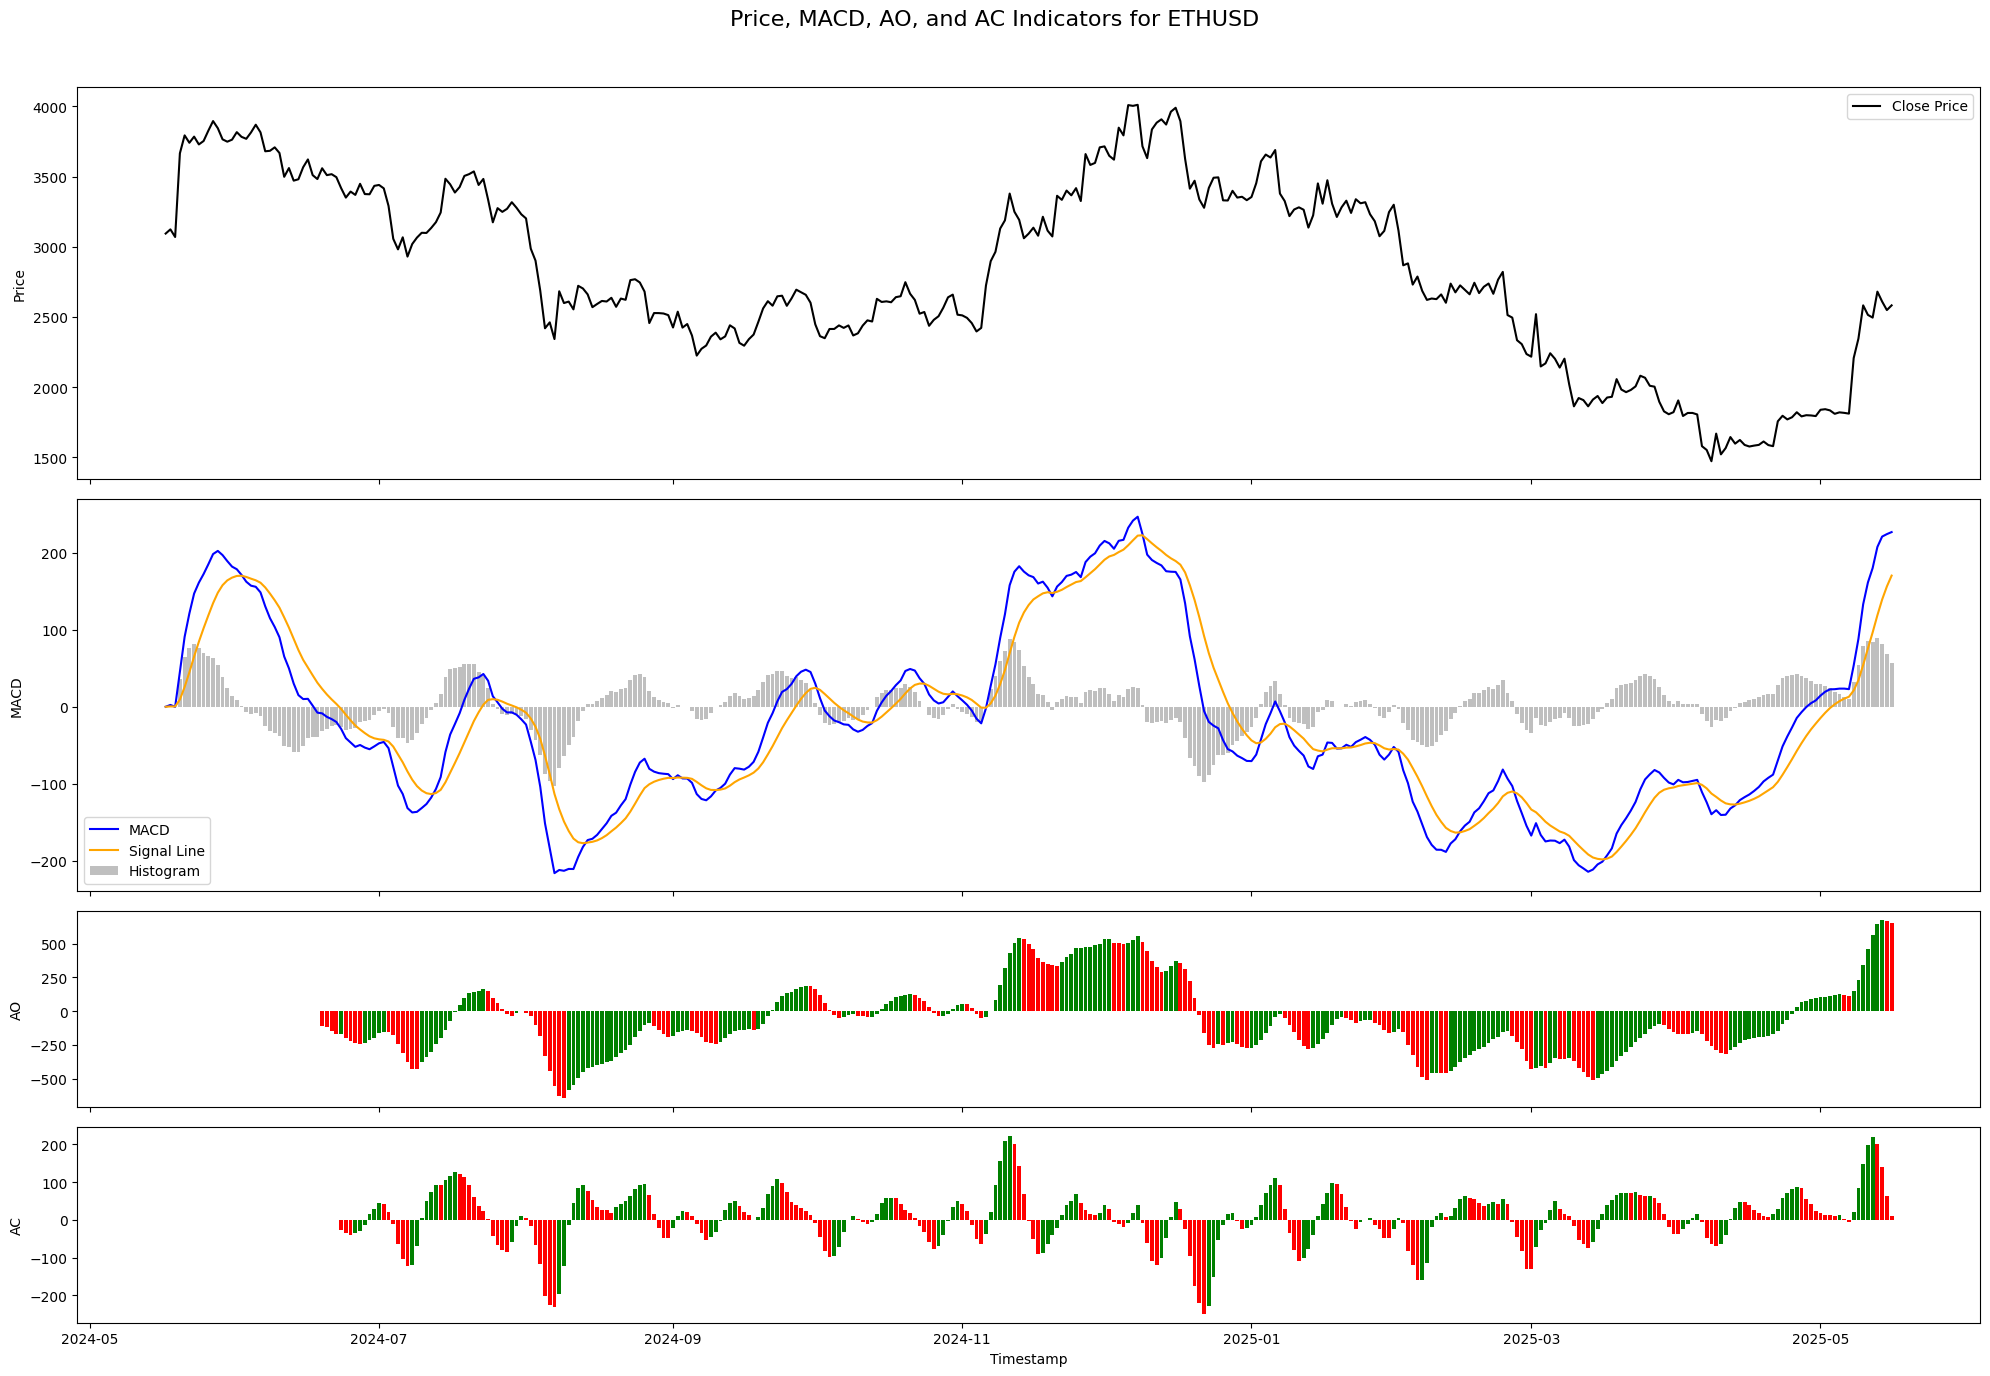

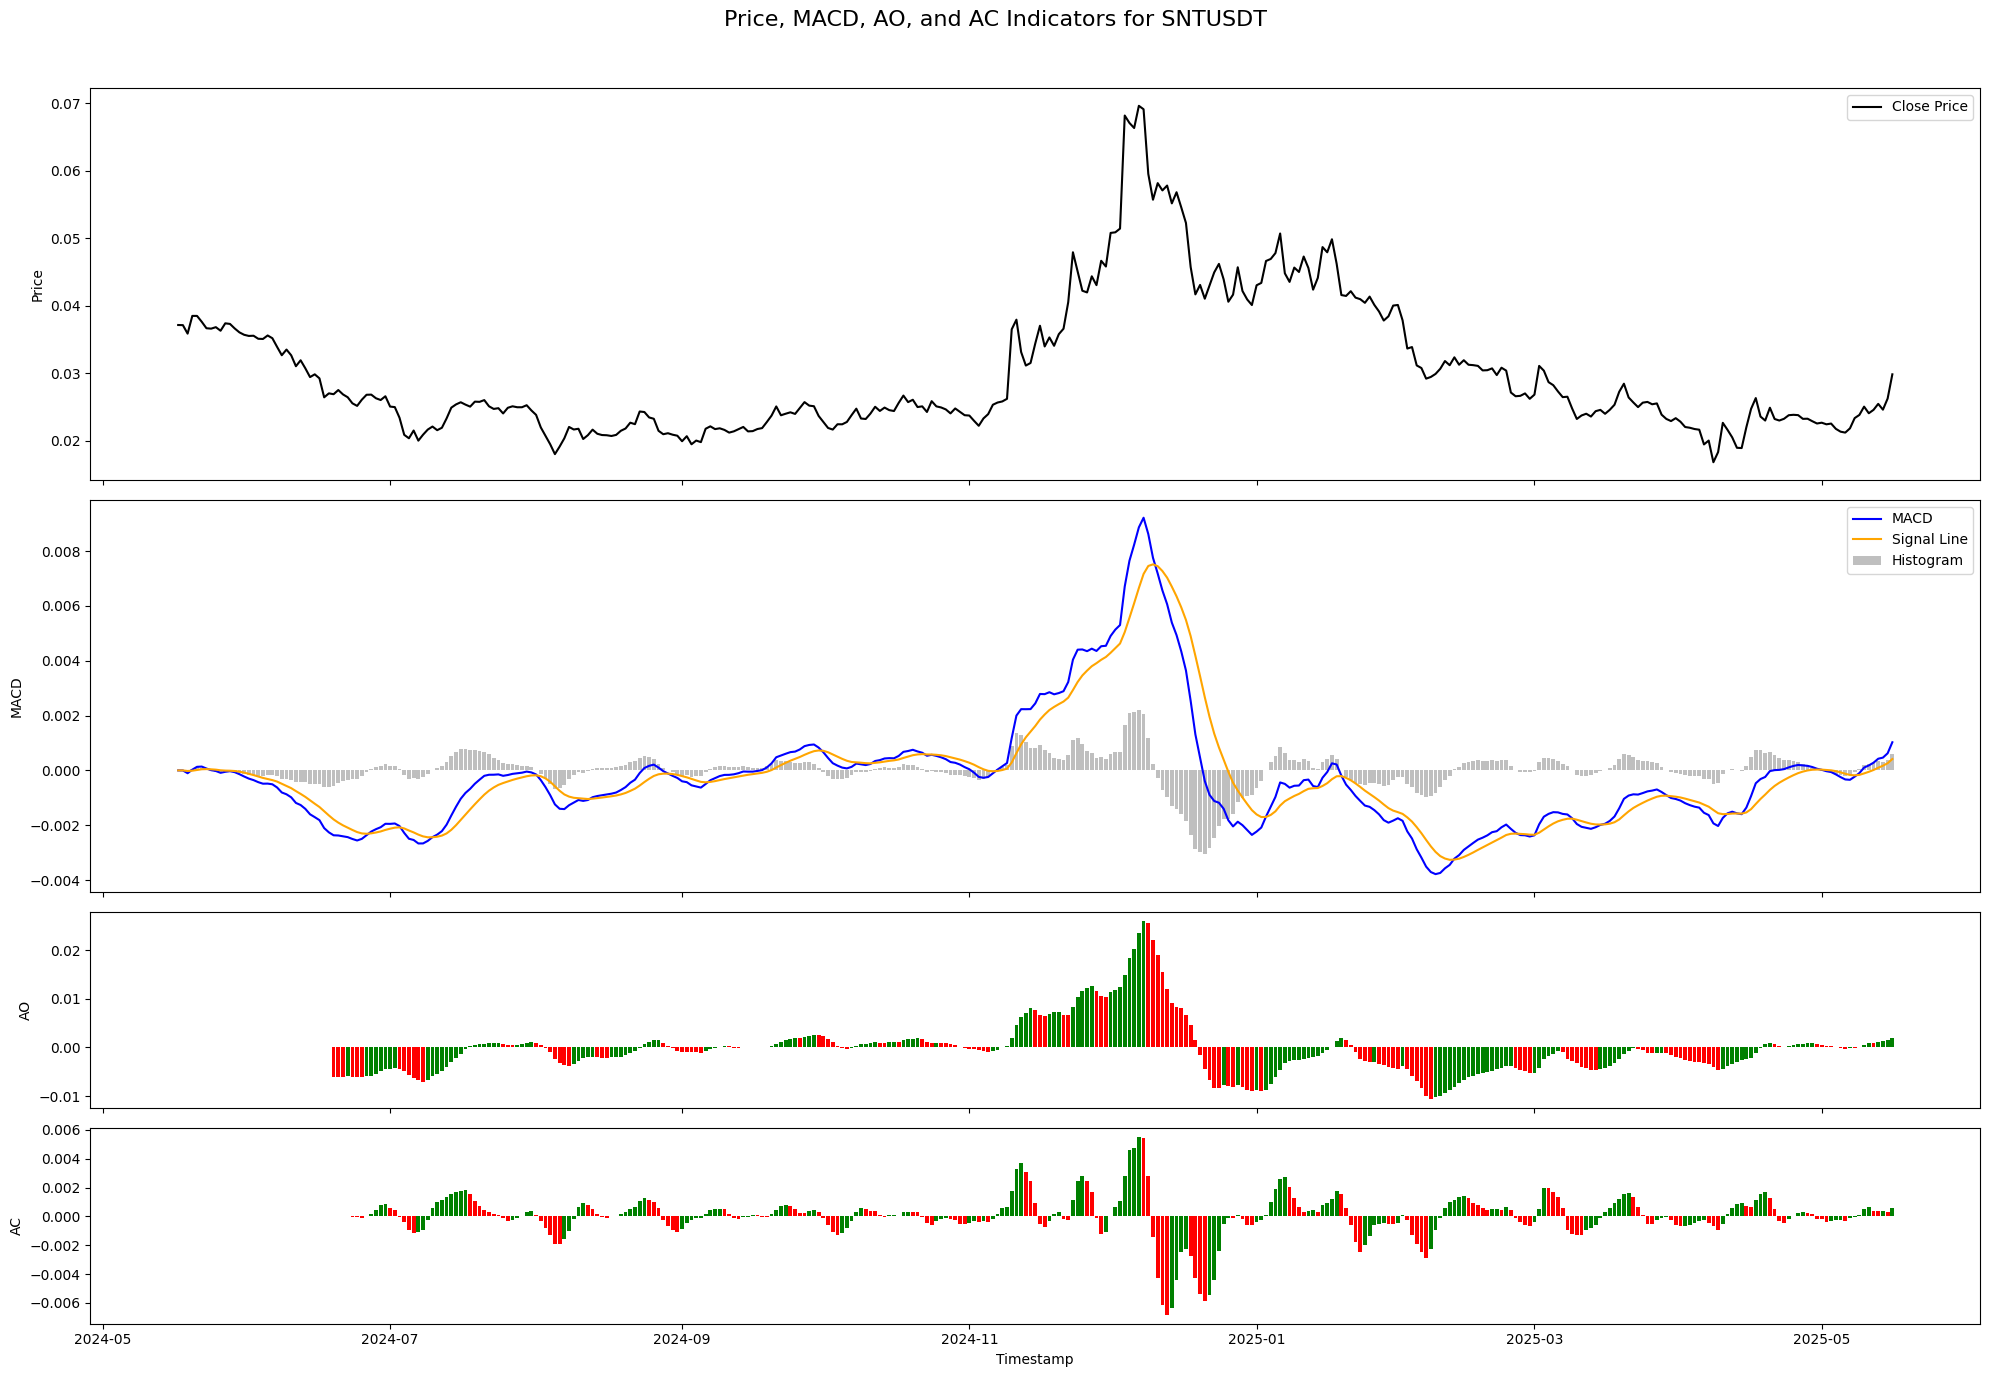

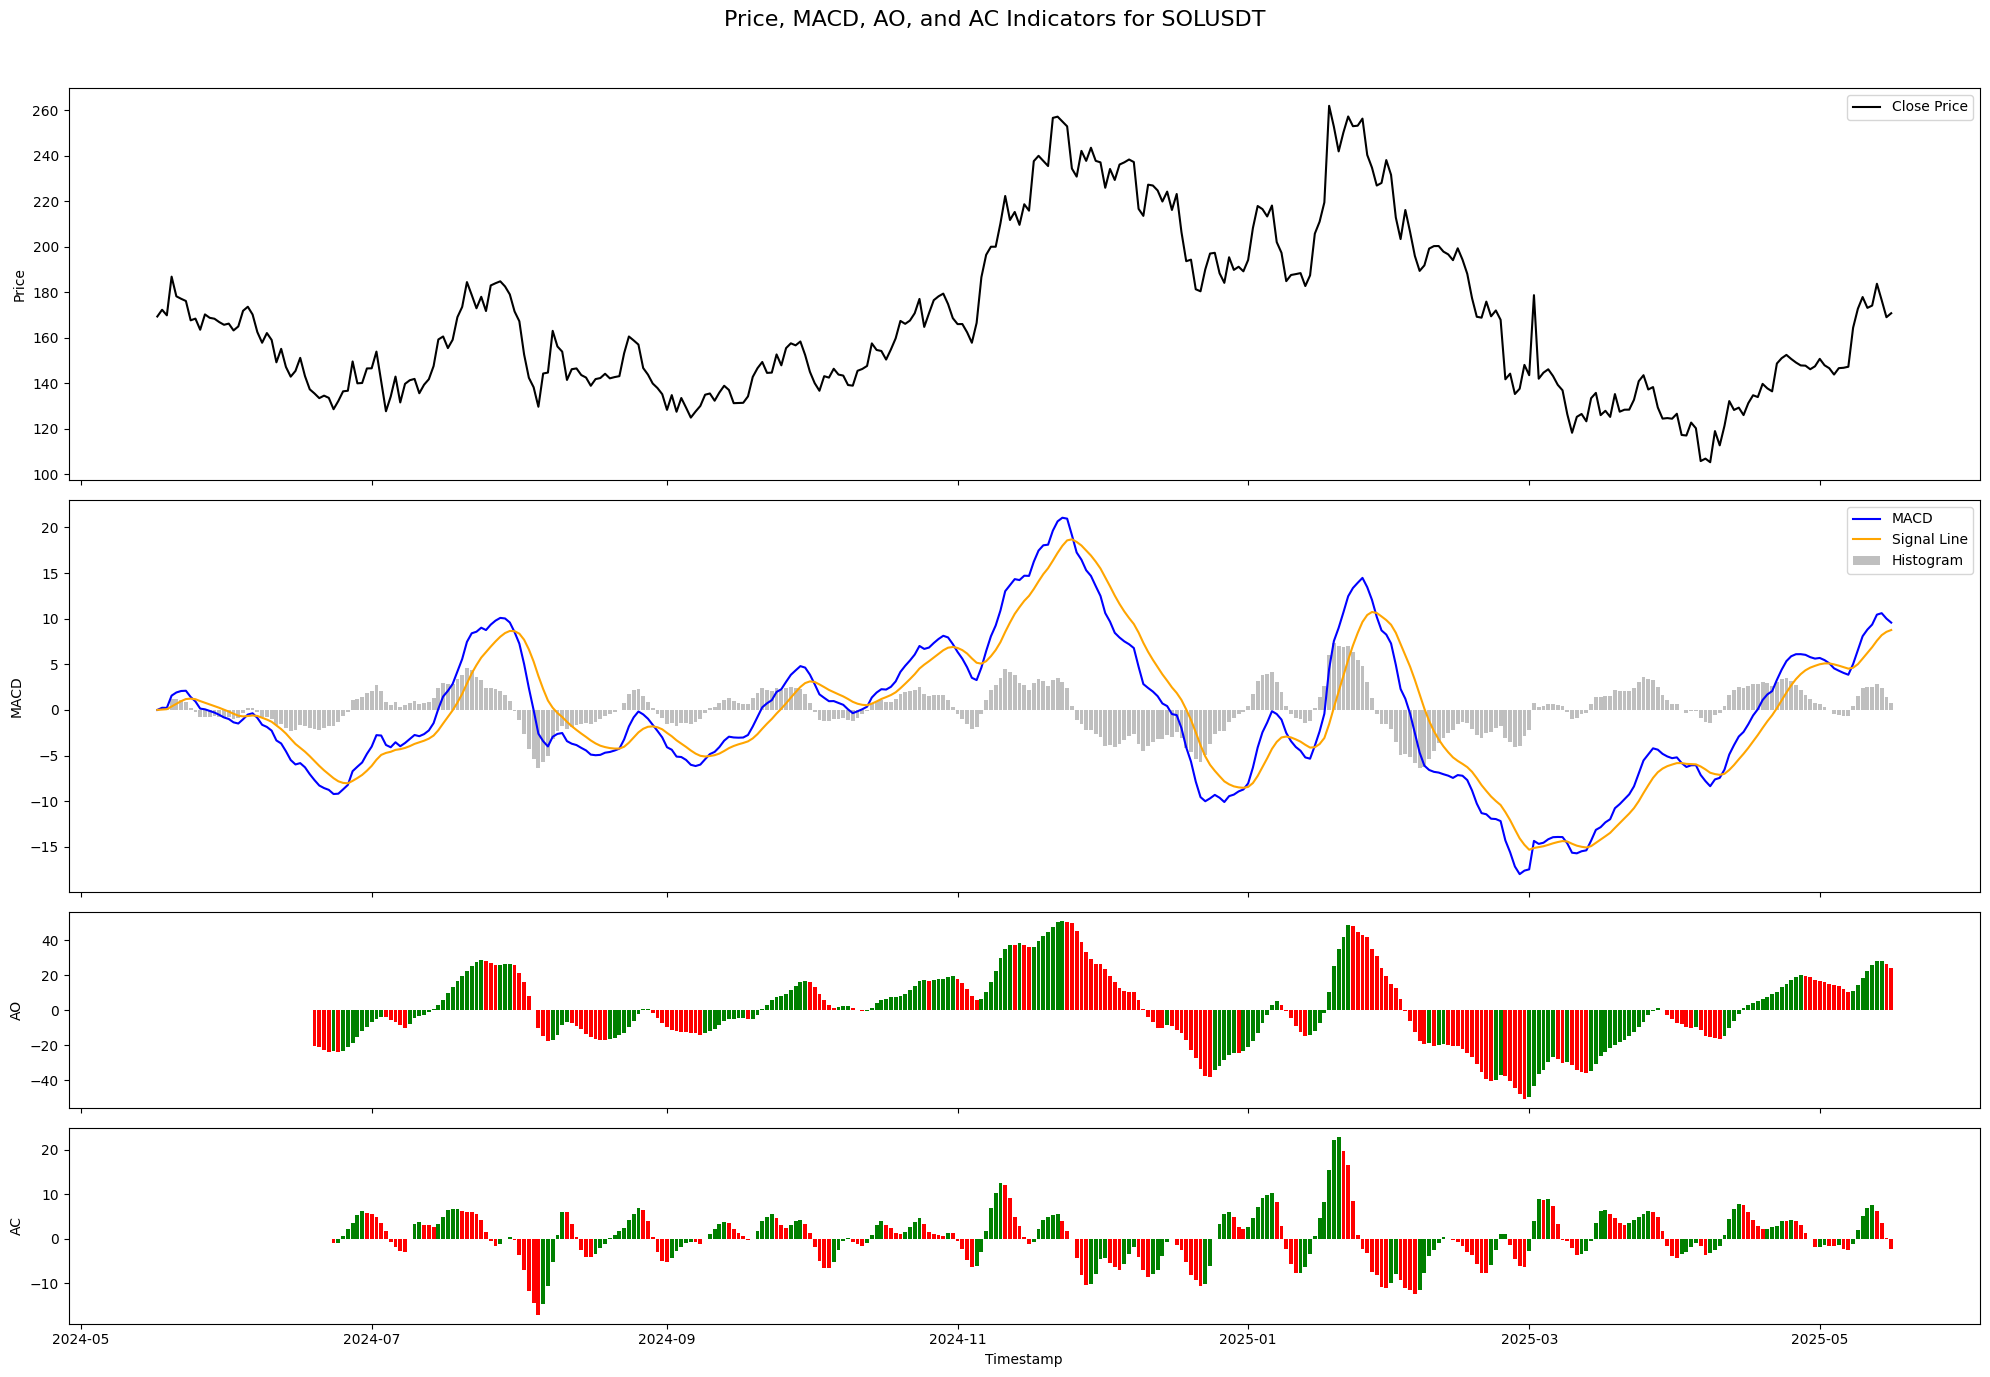

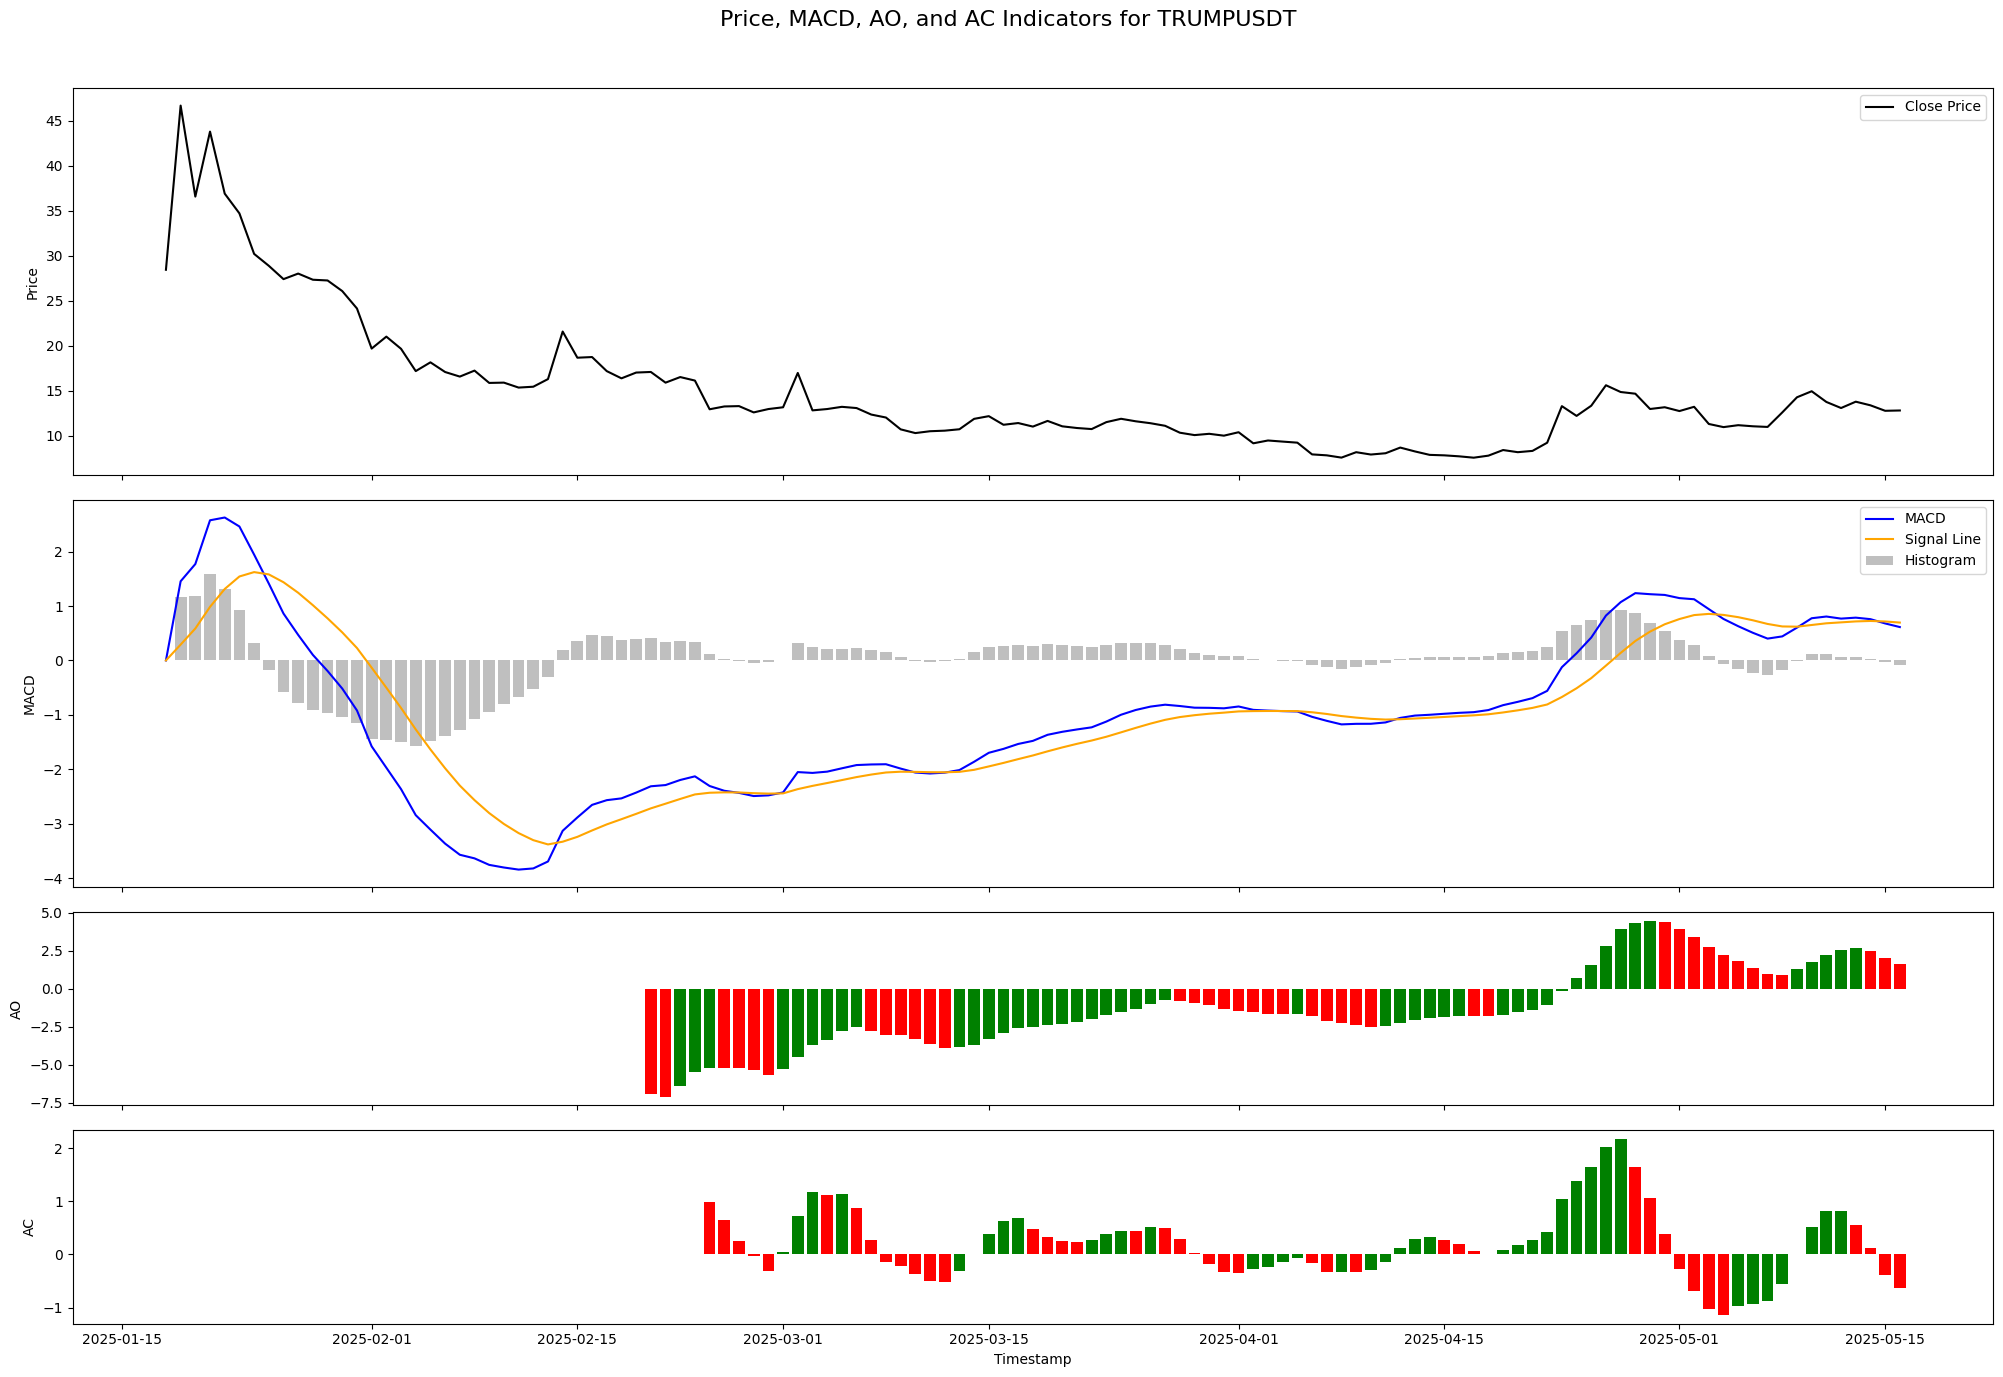

In [7]:
tickers_data_df = tickers_data_df.sort_values(["ticker", "timestamp"])
for ticker in tickers_data_df["ticker"].unique():
    ticker_data = tickers_data_df[tickers_data_df["ticker"] == ticker].sort_values("timestamp").copy()

    ticker_data["ac_color"] = ticker_data["AC"].diff().apply(lambda x: "green" if x >= 0 else "red")
    ticker_data["ao_color"] = ticker_data["AO"].diff().apply(lambda x: "green" if x >= 0 else "red")

    fig, axs = plt.subplots(4, 1, figsize=(20, 14), sharex=True, gridspec_kw={"height_ratios": [2, 2, 1, 1]})
    fig.suptitle(f"Price, MACD, AO, and AC Indicators for {ticker}", fontsize=16)

    # === PRICE ===
    axs[0].plot(ticker_data["timestamp"], ticker_data["close_price"], label="Close Price", color="black")
    axs[0].set_ylabel("Price")
    axs[0].legend()

    # === MACD ===
    axs[1].plot(ticker_data["timestamp"], ticker_data["MACD"], label="MACD", color="blue")
    axs[1].plot(ticker_data["timestamp"], ticker_data["signal"], label="Signal Line", color="orange")
    axs[1].bar(ticker_data["timestamp"], ticker_data["histogram"], label="Histogram", color="gray", alpha=0.5)
    axs[1].set_ylabel("MACD")
    axs[1].legend()

    # === AO ===
    axs[2].bar(
        ticker_data["timestamp"],
        ticker_data["AO"],
        color=ticker_data["ao_color"]
    )
    axs[2].set_ylabel("AO")

    # === AC ===
    axs[3].bar(
        ticker_data["timestamp"],
        ticker_data["AC"],
        color=ticker_data["ac_color"]
    )
    axs[3].set_ylabel("AC")
    axs[3].set_xlabel("Timestamp")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()